## LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2 # Model
from tensorflow.keras import layers, models

In [2]:
import tensorflow as tf
print(tf.__version__)

2.20.0


# K-FOLD CROSS VALIDATION
## TO ESTIMATE MODEL PERFORMANCE

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# --- PARAMETERS ---
K = 5 # Assuming K=5 folds
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 15

# --- DATA GENERATORS ---
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale=1./255)

# --- AGGREGATION LISTS ---
# Initialize lists to store the test metrics from each fold
test_loss_scores = []
test_accuracy_scores = []

# --- K-FOLD LOOP IMPLEMENTATION ---
for fold in range(1, K + 1):
    print(f"\n====================== Starting Fold {fold}/{K} ======================")

    train_path = f"training_folds/fold_{fold}/train"
    test_path  = f"training_folds/fold_{fold}/test"

    train_data = train_gen.flow_from_directory(
        train_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_data = test_gen.flow_from_directory(
        test_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # 2. BUILD A NEW, FRESH MODEL FOR EACH FOLD (Crucial for K-Fold)
    tf.keras.backend.clear_session() # Clear prior model graphs
    
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        # Use the number of classes determined by the data generator
        layers.Dense(train_data.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 3. TRAIN MODEL FOR THIS FOLD
    print(f"Training Model for Fold {fold}...")
    model.fit(
        train_data,
        epochs=EPOCHS,
        verbose=0 # Set to 1 for detailed output per epoch
    )
    
    # 4. EVALUATE AND STORE METRICS (The Aggregation Step)
    print(f"Evaluating Model for Fold {fold}...")
    # model.evaluate returns a list: [loss, accuracy]
    loss, accuracy = model.evaluate(test_data, verbose=0) 
    
    test_loss_scores.append(loss)
    test_accuracy_scores.append(accuracy)
    
    print(f"Fold {fold} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")


# --- FINAL AGGREGATION AND REPORTING ---
print("\n\n====================== K-FOLD CROSS-VALIDATION RESULTS ======================")

# Convert lists to numpy arrays for easy calculation
accuracies = np.array(test_accuracy_scores)

# Calculate the mean and standard deviation
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"\nIndividual Fold Accuracies: {[f'{a*100:.2f}%' for a in accuracies]}")
print(f"Overall Cross-Validation Accuracy: {mean_accuracy*100:.2f}%")
print(f"Standard Deviation of Accuracy: {std_accuracy*100:.2f}%")

print("\n--- Model is estimated to generalize with this performance. ---")


====================== Starting Fold 1/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.

Training Model for Fold 1...
Evaluating Model for Fold 1...
Fold 1 - Test Loss: 0.1072, Test Accuracy: 95.33%

====================== Starting Fold 2/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Training Model for Fold 2...
Evaluating Model for Fold 2...
Fold 2 - Test Loss: 0.2139, Test Accuracy: 92.00%

====================== Starting Fold 3/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Training Model for Fold 3...
Evaluating Model for Fold 3...
Fold 3 - Test Loss: 0.1497, Test Accuracy: 95.33%

====================== Starting Fold 4/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Training Model for Fold 4...
Evaluating Model for Fold 4...
Fold 4 - Test Loss: 0

# MODEL TRAINING

In [4]:
# Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 15 # epoch for train models

# Data Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

# load data / splitting data
train_data = train_gen.flow_from_directory(
    'dataset_split/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    'dataset_split/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Build Model using Transfer Learning
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model layers initially

# Define the full model matrix form
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=test_data, epochs=EPOCHS)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 628ms/step - accuracy: 0.7133 - loss: 0.6671 - val_accuracy: 0.9200 - val_loss: 0.2222
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.9033 - loss: 0.2709 - val_accuracy: 0.9600 - val_loss: 0.1519
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.9300 - loss: 0.1965 - val_accuracy: 0.9600 - val_loss: 0.1363
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.9267 - loss: 0.1950 - val_accuracy: 0.9600 - val_loss: 0.1221
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.9567 - loss: 0.1229 - val_accuracy: 0.9533 - val_loss: 0.1198
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.9533 - loss: 0.1551 - val_accuracy: 0.9600 - val_loss: 0.1419
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.9683 - loss: 0.1059 - val_accuracy: 0.9533 - val_loss: 0.1071
Epoch 8/15
10/10 ━━━━

## MODEL EVALUATION 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step


<Figure size 800x600 with 0 Axes>

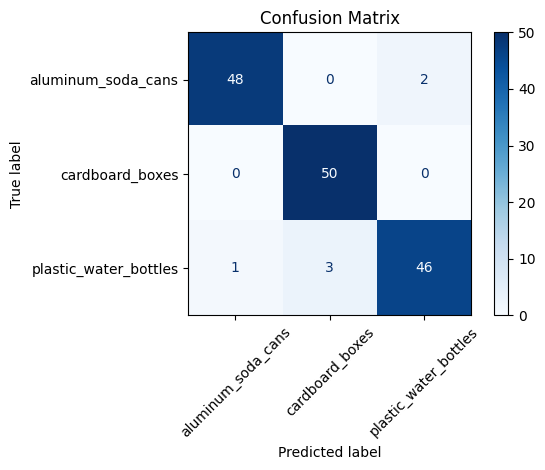

Classification Report:

                       precision    recall  f1-score   support

   aluminum_soda_cans       0.98      0.96      0.97        50
      cardboard_boxes       0.94      1.00      0.97        50
plastic_water_bottles       0.96      0.92      0.94        50

             accuracy                           0.96       150
            macro avg       0.96      0.96      0.96       150
         weighted avg       0.96      0.96      0.96       150



In [5]:
# Predict the classes on test data
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)

# Get true labels and class names
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import sklearn 

# Classification report
report = sklearn.metrics.classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n")
print(report)

# REAL WORLD TESTING

Found 158 images belonging to 3 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


<Figure size 800x600 with 0 Axes>

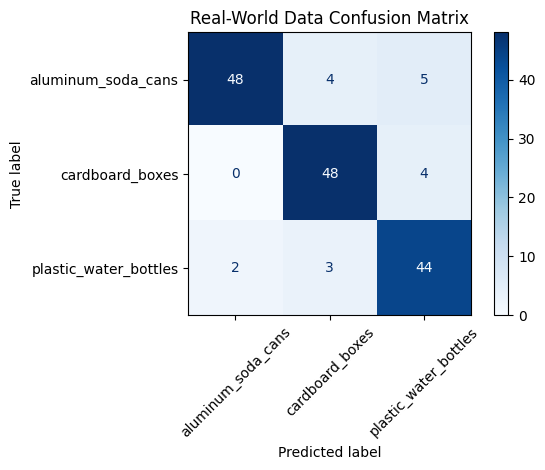

Classification Report on Real-World Data:

                       precision    recall  f1-score   support

   aluminum_soda_cans       0.96      0.84      0.90        57
      cardboard_boxes       0.87      0.92      0.90        52
plastic_water_bottles       0.83      0.90      0.86        49

             accuracy                           0.89       158
            macro avg       0.89      0.89      0.89       158
         weighted avg       0.89      0.89      0.89       158



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -----------------------------
# Load your trained model
# -----------------------------
# If already in memory from training, skip this. Otherwise:
# model = load_model("my_final_model.h5")

# -----------------------------
# Data generator for real-world test data
# -----------------------------
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

real_test_gen = ImageDataGenerator(rescale=1./255)

real_test_data = real_test_gen.flow_from_directory(
    'real_world_data',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # important for correct label order
)

# -----------------------------
# Predict with the trained model
# -----------------------------
pred_probs = model.predict(real_test_data)
pred_labels = np.argmax(pred_probs, axis=1)

# -----------------------------
# Get true labels and class names
# -----------------------------
true_labels = real_test_data.classes
class_names = list(real_test_data.class_indices.keys())

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Real-World Data Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Classification Report
# -----------------------------
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report on Real-World Data:\n")
print(report)
